<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [2]:
import pandas as pd
import re
import emoji
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv("./result0605.csv", engine='python')

type(df["description"])
docs = df["description"].to_list()

In [3]:
print(len(docs))

93794


In [4]:
print(docs[0][:1000])

漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し


### Neologdを使ってtokenizeする

In [5]:
docs

['漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し',
 'D垢。プリンセスよく描いてけど…たまに違うものも描きます。手遅めですがよろしくお願いします🙇🙇 ※名前の読み方は自由なんで好きなように読んでください 最近は低浮上なので…別の絵垢 →@ri_ri_ri_ri_on',
 '𝖒𝖔𝖔𝖓𝖎𝖆𝖓 ♤  𝔣𝔱𝔦𝔰𝔩𝔞𝔫𝔡  ♢ 𝖒𝖎𝖞𝖆𝖛𝖎  ♧  𝔥𝔬𝔦𝔷𝔢𝔯  ♡  𝖇𝖇𝖟  ✩  𝔪𝔢𝔩𝔩𝔬𝔴𝔪𝔬𝔱𝔦𝔣\n˗ˏˋ⋆·˚ ༘ * アララカタブラツルリンコｫォォオ!!✩‧₊˚´ˎ˗.',
 'ENHYPEN、アニメ・漫画 ゲーム関連でTwitter使ってるので、それ以外は無反応です、、',
 '【心にゆとりと潤いを💞】目指すのは学校の保健室のような場所・ホッと一息つける場所｜あなたの幸せを願っています｜職業:音楽の講師｜《自分磨き中》自分らしくあるためのツイート｜思った事を呟きます｜時々ドジ有り｜🐶2匹と🐈4匹がいます🐾',
 '過去にジャパリカート動画、TSUMURI KART(VRChat)など作ったり、ワリスノ(MK8DX)一位だったりした人。\n社会に出てから疲れてる。\n配信→https://t.co/FJoitl8JHE\n\nヘッダの猫の飼い主→@___smmmmm',
 '🔥🎴・💎⚡️・⚡️🎴・👹🎴主の雑多垢🙏 成人20⬆️ic:自作 hd:@kmtmiu_ 様よりフリーヘッダー',
 '18↑ 夢追翔 伏見ガク ガオンくん応援アカウント アークナイツ dbdやってます',
 'スコティッシュ猫アンジェレッタ(2011,06,01生れの女の子）が可愛い過ぎて、毎日猫バカ生活です。\r\n好き☆猫☆動物☆爬虫類☆塊根植物☆藤原竜也☆ﾏﾝｶﾞ・ｱﾆﾒ☆大友克洋☆ＡＫＩＲＡ☆萩尾望都☆せがわまさき☆近藤片岡コンビ☆羽海野チカ☆ベルセルク☆ヒグチユウコ☆リラックマ☆沖縄☆',
 '98line/こもｻﾝ・堀ｻﾝ・健ｻﾝよりall▶LDHall love♡陸ｸﾝよりall↪︎#チームNEXT #ジェネ #ランペ #ファンタ  固定ツイrtいいねお願い ⚠※推し好きな物多め注意報⚠︎ /田中氏よりall▶ #スト #teamSixTONES ▶ #介護福祉',
 '21年毎日更新ブロ

In [6]:
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
import MeCab
m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))


def neolog_prep_text( text):
  return_words = []
  splited_text = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
  for tmp_word in splited_text :
    if (tmp_word[0] in ('EOS', '', 't', 'ー') ):
       continue 
    if not re.match( '名詞' ,tmp_word[3]  ) or tmp_word[0] in emoji.UNICODE_EMOJI["en"]:
      continue
    else:
      return_words.append(tmp_word[0])
    
    
    # 1回しかでてこないのを削る。

  return return_words

* tokenizationの実行

In [7]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  if str(doc) == "nan":
    continue
  tmp_words =  neolog_prep_text(str(doc))
  new_docs.append( tmp_words )
  

100%|██████████| 93794/93794 [00:24<00:00, 3864.04it/s]


* tokenizationの結果を確認

In [8]:
print(new_docs[5])

['過去', 'ジャパリカート', '動画', 'TSUMURI', 'KART', 'VRChat', 'ワリスノ', 'MK', '8', 'DX', '一位', 'りし', 'た人', '社会', '出て', '配信', 'https', 'co', 'FJoitl', '8', 'JHE', 'ヘッダ', '猫', '飼い主', 'smmmmm']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [9]:
corpus = [' '.join(doc) for doc in new_docs]

In [10]:
new_docs

[['漫画',
  'アニメ',
  '声優',
  '垢',
  'RT',
  '多め',
  '気まま',
  '伏線',
  '系',
  '漫画',
  '好き',
  '古川慎',
  'さん',
  '小林裕介',
  'さん',
  '河西健吾',
  'さん',
  '田丸篤志',
  'さん'],
 ['D',
  '垢',
  'プリンセス',
  'たま',
  'もの',
  '手遅',
  'め',
  'よろしくお願いします',
  '名前',
  '読み方',
  '自由',
  '好き',
  'よう',
  '最近',
  '浮上',
  '別',
  '絵',
  '垢',
  'ri',
  'ri',
  'ri',
  'ri',
  'on'],
 ['アララカタブラツルリンコｫォォオ', '₊'],
 ['ENHYPEN', 'アニメ', '漫画', 'ゲーム', '関連', 'Twitter', 'それ', '以外', '反応'],
 ['心',
  'ゆとり',
  '潤い',
  'の',
  '学校',
  '保健室',
  'よう',
  '場所',
  '一息',
  '場所',
  'あなた',
  '幸せ',
  '職業',
  '音楽',
  '講師',
  '自分磨き',
  '中',
  '自分',
  'ため',
  'ツイート',
  '事',
  'ドジ',
  '有り',
  '2',
  '匹',
  '4',
  '匹'],
 ['過去',
  'ジャパリカート',
  '動画',
  'TSUMURI',
  'KART',
  'VRChat',
  'ワリスノ',
  'MK',
  '8',
  'DX',
  '一位',
  'りし',
  'た人',
  '社会',
  '出て',
  '配信',
  'https',
  'co',
  'FJoitl',
  '8',
  'JHE',
  'ヘッダ',
  '猫',
  '飼い主',
  'smmmmm'],
 ['主', '雑多', '垢', '成人', '20', 'ic', '自作', 'hd', 'kmtmiu', '様', 'フリーヘッダー'],
 ['18', '夢追翔', '伏見', 'ガク', 'ガオン

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [11]:
import os
import urllib.request
def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

File already exists.


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=30, stop_words=stop_words)
X = vectorizer.fit_transform(corpus)

In [13]:
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0m', '0t', '0v', '0w', '0歳', '10', '100', '1000', '1000人', '10年', '10年目', '10時', '10月', '10歳', '11', '110', '11月', '11歳', '12', '120', '123', '125', '12年', '12月', '12歳', '13', '13年', '13歳', '14', '14年', '14歳', '15', '150', '15年', '15歳', '16', '16年', '16歳', '17', '17歳', '18', '18年', '18歳', '18歳以上', '18禁', '19', '19年', '19時', '19歳', '1b', '1d', '1q', '1t', '1v', '1w', '1つ', '1人', '1位', '1児', '1回', '1年', '1年生', '1年目', '1度', '1日', '1月', '1歳', '1番', '1級', '20', '200', '2000', '2010', '2010年', '2011', '2011年', '2012', '2012年', '2013', '2013年', '2014', '2014年', '2015', '2015年', '2016', '2016年', '2017', '2017年', '2018', '2018年', '2019', '2019年', '2020', '2020年', '2021', '2021年', '20代', '20代後半', '20年', '20時', '20歳', '21', '21時', '21歳', '22', '22時', '22歳', '23', '23歳', '24', '24時間', '24歳', '25', '250', '2525', '25歳', '26', '26歳', '27', '27歳', '28', '28歳', '29', '29歳', '2b', '2d', '2g', '2nd', '2q', '2t', '2v', '2w', '2x', '2z',

In [14]:
print(len(vectorizer.get_feature_names()))

5100


* 文書数と語彙サイズを変数にセット

In [15]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [17]:
print(Xtfidf[0])

  (0, 4227)	0.603862693464167
  (0, 4148)	0.4706802938434637
  (0, 3490)	0.1847556021921528
  (0, 3414)	0.33418592758883475
  (0, 3402)	0.3582132311126842
  (0, 1747)	0.24047370992039763
  (0, 1109)	0.28609564411708244


In [18]:
Xtfidf.shape

(88481, 5100)

In [19]:
n_components = 8

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [20]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [21]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=88481 and n_features=5100
Epoch 10 reached after 2.299 seconds, error: 1505.882560
Epoch 20 reached after 4.435 seconds, error: 1503.960840
Epoch 30 reached after 6.574 seconds, error: 1503.388781
Epoch 40 reached after 8.714 seconds, error: 1503.116205
Epoch 50 reached after 10.860 seconds, error: 1502.929890
Epoch 60 reached after 13.009 seconds, error: 1502.791030
done in 13.949s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [22]:
nmf.components_

array([[1.90754691e-03, 1.38892962e-15, 1.05341928e-02, ...,
        5.20358340e-04, 1.39101937e-03, 5.66794952e-03],
       [1.02606004e-01, 7.73614217e-03, 2.84622017e-02, ...,
        7.46313444e-03, 0.00000000e+00, 0.00000000e+00],
       [7.11351131e-03, 7.62933019e-15, 1.57643711e-02, ...,
        9.08120449e-03, 1.53444997e-02, 2.72581694e-02],
       ...,
       [8.20919155e-03, 7.34007149e-03, 3.71441203e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.62249073e-01, 7.39297642e-08, 1.17306792e-01, ...,
        2.76660085e-07, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.92853321e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [23]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [24]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [25]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [26]:
topic_words[0]

{'好き': 4.103561187905856,
 '映画': 0.5315387393311308,
 '音楽': 0.41431443245389565,
 '鬼滅の刃': 0.3270085230577755,
 '最近': 0.3126112676608199,
 '趣味': 0.2872958539668996,
 'アニメ': 0.2869918530392826,
 '動物': 0.275933891461783,
 '写真': 0.2360770362433886,
 '特撮': 0.22549088407547632,
 'バイク': 0.20338502455537907,
 'ファン': 0.19834733293741058,
 'おじさん': 0.19702775838594988,
 '漫画': 0.1920570610451646,
 'カメラ': 0.1807495261802483,
 '作品': 0.17139416059942497,
 'フォロー': 0.1709908814945777,
 '先生': 0.16624620182239117,
 '応援': 0.1647405475615883,
 'ディズニー': 0.16290116282428538,
 '読書': 0.1535491360374692,
 'おっさん': 0.15195349289906301,
 '気軽': 0.14873212461521124,
 '野球': 0.14561156863762467,
 '仮面ライダー': 0.144788295139377,
 '鉄道': 0.1438294936509801,
 'etc': 0.13752199434160717,
 '担当': 0.13729905718906268,
 '男子': 0.13424759419158924,
 'ねこ': 0.13406788313179405}

### 重要語をワードクラウドで可視化

In [27]:
from matplotlib import pyplot as plt

* ワードクラウドから除去するストップワードを確認する。

* ワードクラウドを描画

In [28]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

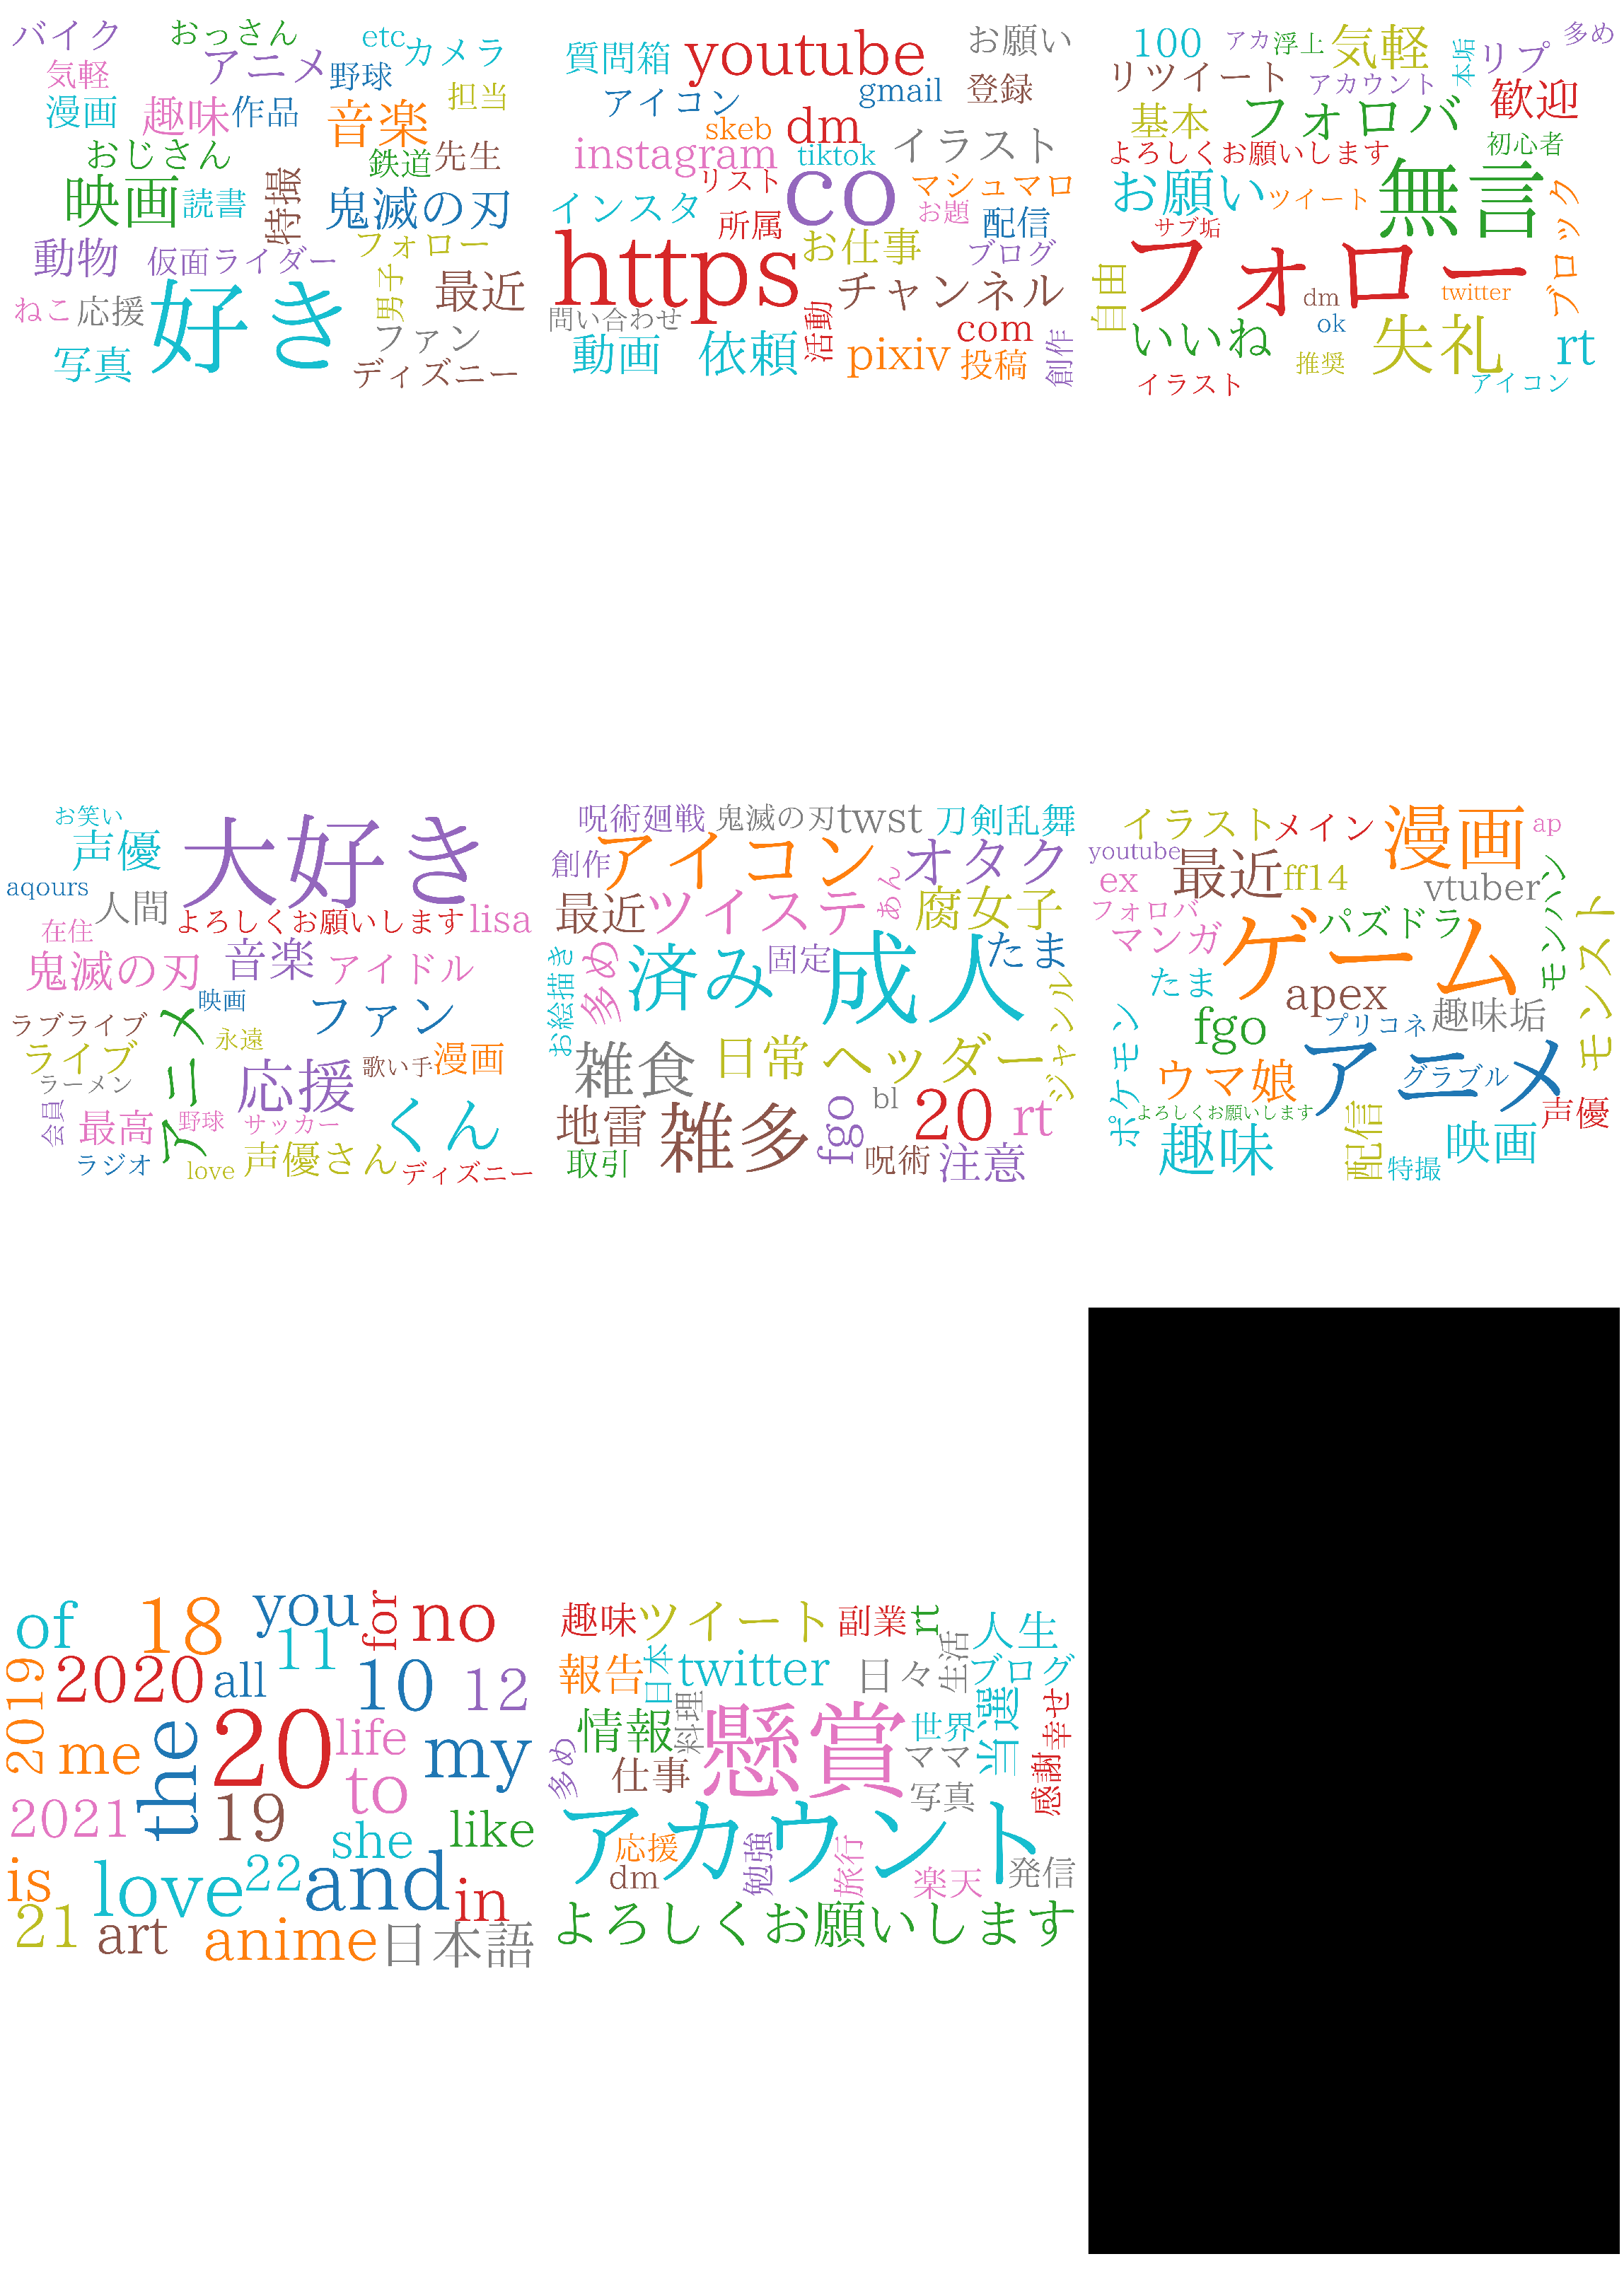

In [29]:
# fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)
tate = math.ceil(n_components / 3)
fig, axes = plt.subplots(tate, 3, figsize=(32, 50), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [30]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=30,
                                topic_word_prior=0.25, # トピック数の逆数が目安の0.01,0.02,0.05,0.1などなど試す
                                learning_method='online',
                                learning_offset=50,
                                batch_size=1000,# 多くする
                                # learning_decay : 2??
                                
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)
# パラメータの比較はperplexity
# ハイパーパラメータ調整を頑張る！（やってられない！といわない！！）

In [31]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=88481 and n_features=5100
iteration: 1 of max_iter: 30, perplexity: 1678.0427
iteration: 2 of max_iter: 30, perplexity: 1580.9908
iteration: 3 of max_iter: 30, perplexity: 1543.2473
iteration: 4 of max_iter: 30, perplexity: 1523.8411
iteration: 5 of max_iter: 30, perplexity: 1511.8999
iteration: 6 of max_iter: 30, perplexity: 1504.3227
iteration: 7 of max_iter: 30, perplexity: 1499.3217
iteration: 8 of max_iter: 30, perplexity: 1495.7266
iteration: 9 of max_iter: 30, perplexity: 1493.0391
iteration: 10 of max_iter: 30, perplexity: 1491.0210
iteration: 11 of max_iter: 30, perplexity: 1489.3337
iteration: 12 of max_iter: 30, perplexity: 1488.0158
iteration: 13 of max_iter: 30, perplexity: 1486.9328
iteration: 14 of max_iter: 30, perplexity: 1485.9493
iteration: 15 of max_iter: 30, perplexity: 1485.1551
iteration: 16 of max_iter: 30, perplexity: 1484.4410
iteration: 17 of max_iter: 30, perplexity: 1483.8197
iteration: 18 of max_iter: 30, perp

### LDAの各トピックから高確率語を取り出す

In [32]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [33]:
print(top_words[0])

['好き', '大好き', '懸賞', '当選', '人生', '報告', '趣味', 'lisa', 'ママ', '日々', '旅行', '仕事', '料理', '幸せ', '息子', '家族', 'お酒', '感謝', 'バイク', '主婦', '生活', '音楽', '筋トレ', '最近', '子供', '子育て', '在住', '美容', '副業', 'go']


In [34]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [35]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

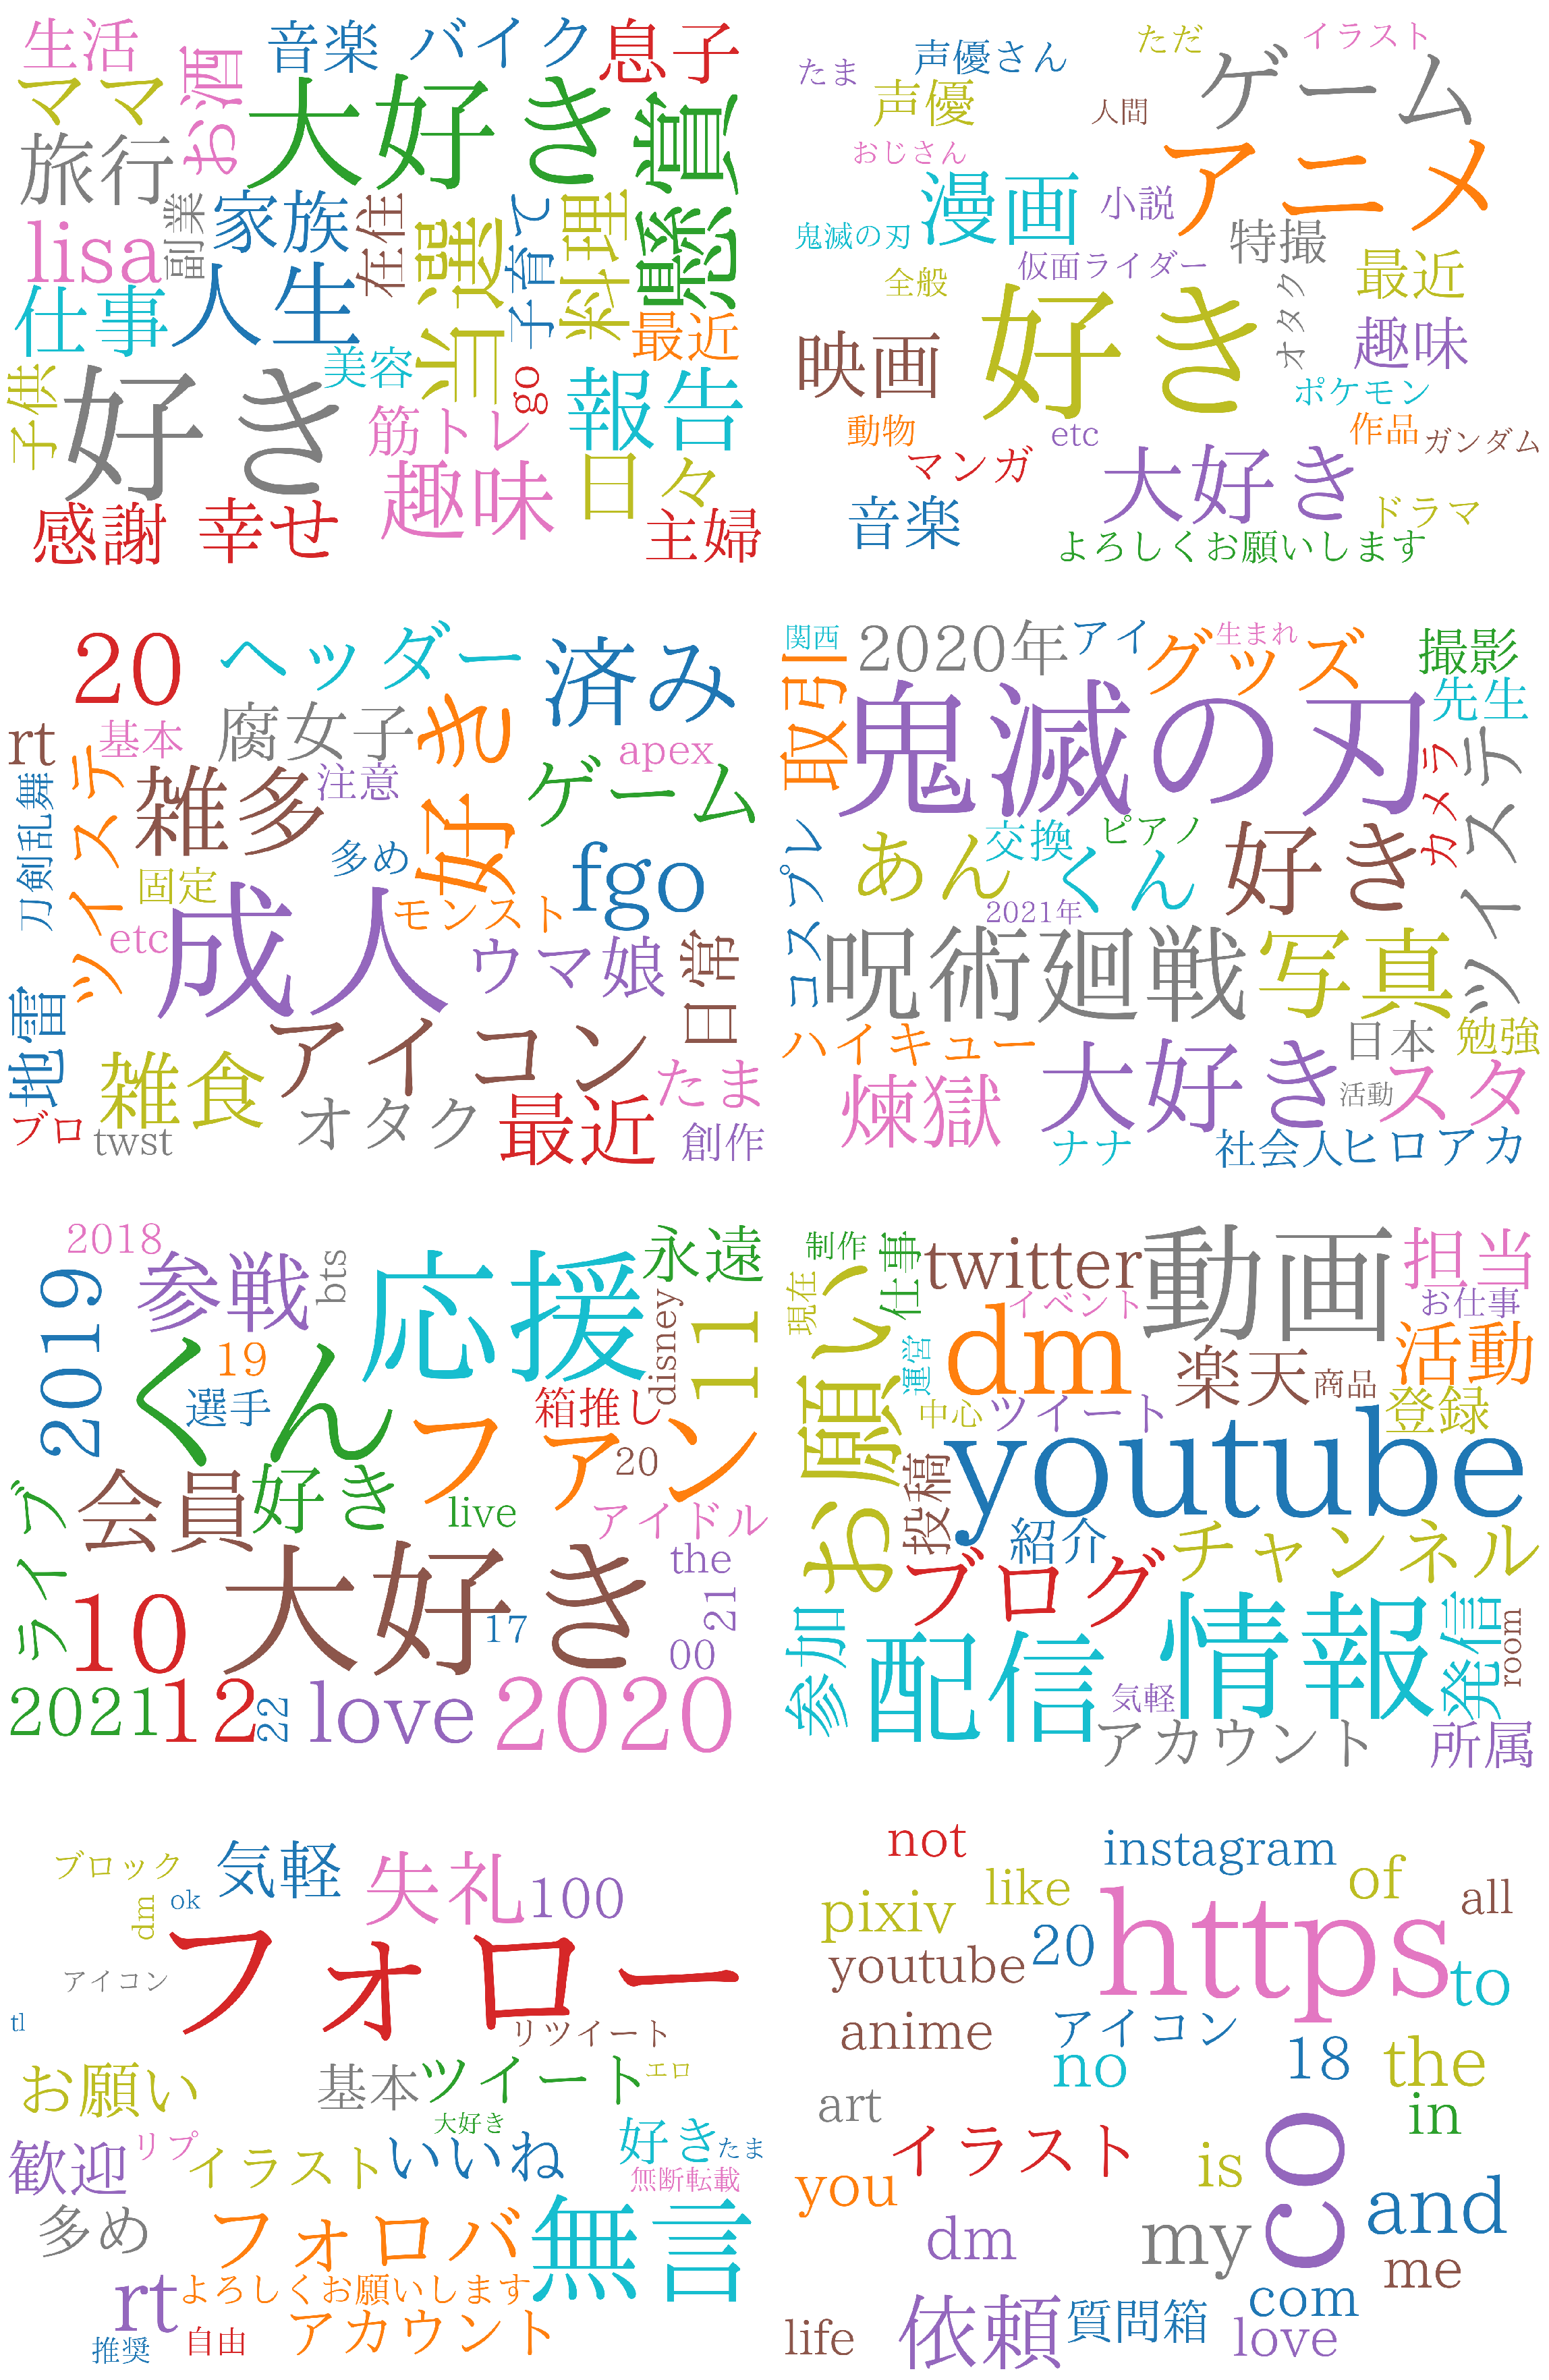

In [36]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
tate = math.ceil(n_components / 2)
fig, axes = plt.subplots(tate, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break

  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()


from matplotlib.backends.backend_pdf import PdfPages

import datetime
pdf = PdfPages( 
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


fignums = plt.get_fignums()
for fignum in fignums:
    plt.figure(fignum)
    pdf.savefig()

pdf.close()

In [37]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names(), 100)

In [38]:
def get_top_prof (topic_idx, top_n = 100):
    
    topics = lda.transform(X)
    prof_idx_list = topics[:, topic_idx].argsort()[:-top_n - 1:-1]
    return [docs[d] for d in prof_idx_list]

In [39]:
import pickle

file_name = (datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + '_lda.pickle'
with open(file_name, mode="wb") as f:
    pickle.dump(lda, f)

In [40]:
get_top_prof(0, 20)

['ラブライブ好きな人〜仲良くして〜 μ’s→ことり(・8・) Aqours→ヨハネ推し 『ギラるん』うみまるさんに命名していただきました！ ライバーの方フォロバします😆 推し作家→ミル先生・ぶそん先生！🔥🔥🔥 𣷓月こけしさん激推し✨✨ 無言フォロー失礼します。m(_ _)m',
 '関西在住の夫小娘付の成人済おばはん猫好、只今銀魂、沖神沼中 たまに家族、好きな物等しょうもないことを呟きます。お返事遅く勝手フォローします🙏\nアイコンはつるとんたんさんからヘッダーは暗黒さんからの頂き物ですので転載等御遠慮願います🙏',
 '近畿圏在住50代生主。今年でニコ生歴12年目。配信者歴6年目です 主に雑談メインの放送します。',
 'サッカー好き！でもやるのは苦手😁 趣味はサッカー観戦、漫画、アニメ、ゲーム、映画鑑賞、フィギュア集め❗️趣味用サブ垢😝',
 '承承！承承承承！43がイチオシだけ3456どの組み合わせも美味しいです。他の好きなのはプロフにて（こっちは18歳以上の相互様のみ）→ @mromroboys 他ジャンルもつぶやくよ',
 '21',
 'アニメ・漫画・ゲーム好きのツイ廃猫です。TLをよく荒らします。ご了承ください。クロブ/マキオン/DFFNT/FGO/遊戯王DL/ウマ娘/宝石の国/ジョジョ/牙狼\n\n3日反応なければ多分ﾀﾋんでるから',
 '雑多アカ▷ 約ネバ / ヴァイオレット・エヴァーガーデン / ラブライブ！ / ヒプマイ/ UVERworld / Aimer / BUMP ..他にも色々🌻エマたんに萌えるのが生きがい☺️推しなど詳細はツイフィ記載。描いたイラストはこちら▷@y_Kyun166582',
 'アズールレーンと原神にハマってる成人オタクです。 カプ厨注意。最近、子豚の自覚が芽生えつつ有り（🐽',
 '映画 #cateblanchett',
 'ゲームやフィギュア好き。\n最近遊んでるゲームは、プリコネR、城プロRe、Deep One、装甲娘、マギレコ、DOAVVなど。\nYoutubeで動画も出してます。\n良かったらチャンネル登録もお願いします。\nhttps://t.co/PDM4wkEXpY',
 nan,
 '料理、ワイン好き/他には海外旅行や飛行機や鉄道やグルメが好き/好きな女優は川口春奈/好きな歌手はBSB、Shak

In [41]:
get_top_prof(1, 20)

['まどかです17♀｜何も取り柄のない語彙力5歳児未満がここにいます🤪｜推しにめろめろなｱﾆｦﾀです😇｜歌い手さんｦﾀｸでもあります←｜ﾌｫﾄﾅ🔫C2S2から🙌🏻🙆🏻\u200d♀️ぼっちﾌﾟﾚｲﾔｰなう😷｜Switch兼ﾌﾟﾚｽﾃ民｜',
 '初めまして😋 5.3歳ままです😊 黒色すみれちゃんを娘と一緒に応援しています😄 ヒグチユウコさんも好きです😄最近ブライスちゃん、りかちゃんにハマりました。仲良くしてくださいね💓',
 '2010年 一途な男子★2014年 おしゃれな女子★ 音楽と旅行とディズニーとドライブが大好き(≧ε≦)育児時々モンハン♪MHXX＆MHW＆モンハンライズ超初心者…!!くちょ下手!!!!お手伝いお願いしますっ!!!!超エンジョイ勢♪ GLAY HISASHI激推し。follow me(*●艸∀$)♪ 下は質問箱♥️♥️',
 '趣味で大人向け小説を書いています。絵も描きます。 ✦エブリスタ：https://t.co/AXLzjXdhcg ✦なろう：https://t.co/EtNO4eX00Q ✦アルファ：https://t.co/RJwkkI0wJb',
 '20↑♀悠仁に幸せになって欲しいと願うアカウント。宿儺と五条も推し。🐯右。ジョジョ視聴中(1,3視聴済み4部)',
 'Ｓａｐ です よろしくお願いします／グラフィックデザイナー／体操／声優になりたい/イタリア人🇮🇹／DJ\n\n\nItalian/English/日本語\n\nしゅかしゅ💙 \n\nINSTAGRAM = https://t.co/k6sWhR4nsC',
 '乃木坂,日向坂"大好きな"高校3年生です/受験生/進学に向けて頑張ってます!/ライフル射撃部/受験生/乃木坂箱推し◢⁴⁶/推しメン→ #生田絵梨花 #賀喜遥香 #齋藤飛鳥 #白石麻衣 #西野七瀬 #堀未央奈 #松村沙友理 #山下美月💕日向坂46→#小坂菜緒 #佐々木美玲 💕︎気軽にフォローお願いします!!(≧∇≦)',
 '声優:KENNさん.柿原徹也さん.岡本信彦さん/アニメ色々見てる！/声優好きさん、同担さん探してます/未成年でもよければ…！/テニプリブーム来てます',
 'あざらし、またはイチト。大体心が忙しい◎TRPG企画創作ゲーム日常ごったに成人垢◎参加企画はこちら(https://t.co/fDru

In [42]:
get_top_prof(2, 20)

[nan,
 'アニメ、声優さん大好きです。  \n寺島惇太さん、立花慎之介さん、矢野奨吾さん、内田雄馬さん、小野友樹さん、新垣樽助さん、高橋広樹さん、日野聡さん、江口拓也さん\n#ギヴン ❤立夏&真冬応援団✨\n#センチミリメンタル ❤\n#東京卍リベンジャーズ マイキー、ドラケン❤\n            \n好きな俳優:町田啓太さん❤',
 '鈴木福くんの大ファンです！ 台湾人です！！\u3000',
 'PS5欲しい',
 '【音楽】→都内にてNewアルバム製作中！\nmyバンド→【救済魔神yayoi】→@931_BAND\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n【活動】→独語、登山、漫画、アニメ、ポケモン、ペット(犬)、メダカ、ビオトープ、アクアテラリウム、モンハン、作曲、バンド。',
 nan,
 '絵描くの好きです\nあと、ゲームではツムツムとブロスタをよくやってます',
 '洋画で超偏嗜好で連続TWする映画fanアカ。★★フォロ/リムご自由に★★一部アメコミから国際映画祭、音楽、そして食、政治まで【自分の趣味興味嗜好】で雑多。本アカはまず自分自身の情報input用の為、日常RT数かなり多！ですが手作業です。率直映画感想は別アカ。',
 'Sasukeさま、内田真礼さまをゆる〜く推してるどこにでもいるJKです°ʚ(*´˘`*)ɞ°プリッとさまか声優さまについて謎に語ってます笑\n ほんとに気軽に話し掛けてください♡\n フォローの際に一言頂ければすぐ向かいます⸜❤︎⸝\u200d',
 '高校生です 今年受験生… 木曜日は声優と夜あそびの木曜組の呟きが多いです｡ #浪川石川と夜あそび 🌙*.｡★*ﾟ ｶｸｺﾞｼﾃﾈ✩',
 nan,
 'ごめんな映えなくて',
 '20↑ 関西住みレイヤー、シリウスが生きているこの世に感謝。最近はモストロ・ラウンジのATM\u3000ディズニー/USJ/アリス/ハリポタ/あんスタ/OP/HQ/twst',
 '誰とでも仲良くしたい学生です。 フォロバ98% 落下の天才仲間@0_archan_0兄ちゃん@HAKU_tech',
 '二乃推し みっちぃ推し サバゲ ゲーム 長野県民 うんち 女子小学生です',
 "抱き枕/アニメ/ゲーム/ギター/同人音声作品/B'zが好きないい歳したおっさんです。最近T

In [43]:
get_top_prof(3, 20)

['King ＆ Princeの平野紫耀、永野芽郁、 文豪ストレイドッグス、文豪とアルケミスト、free、その他諸々大好きです❣️たくさん絡めると嬉しいです！',
 'もろもろのアカウントです',
 '洋楽🇺🇸🇬🇧／日本の歌🇯🇵／Free Soul🎤／Disco Music🌃／Jazz🎷／coffee☕／サッカー⚽／栃木美女👩／🎵TOCHIGI GROOVE🎶／(アイコンは「とちおとめ」ヘッダーは「正嗣のぎょうざ」)',
 '好きなものを好きなだけ推してなにが悪いｯｯｯ！！！！！',
 'ダンス＆ロックメタルバンドASURA（@ASURA2033）でベースを弾いております♪    youtubeでベースカバー始めました💡 https://t.co/IvyXF7aSkA',
 '神と名乗ってます🥴フォロバ100%！個ツイ見てね！！相棒→(＠kotanuki_0620)ゲーム垢→(@Akaneko_100)',
 'มิน 18⬇️ (Multidom)  คู่ชิปโพไม่แมส| INFP\u200b  📍:JJK BC MHA\u200b  @JJS_Nutsu\u200b',
 'アニメ、漫画、コスプレ、ドール、2次元が好き。会社員×レベル2(年目)のブログで副業をしています。ブログ収益は少しずつ上昇中⤴️起業するのが目標。2次元オタク情報（アニメ・漫画・声優など）、ブログ、起業を中心につぶやきます。',
 '不定期に怪談話(カイダンバナシ)をyoutubeにて配信している「ぱんち」と申します！こちらはゲーム実況専用アカウントです！！ゲームにご興味ある方、こちらもよろしければチャンネル登録&フォローお願い致します！！\n\nカイダン。アカウント : @kaidan_story2',
 'ツイステ、鬼滅の刃、大好き💙💛只今、ジェイド、善逸推しです。 声優さんも好き✨',
 'league of legends❤️(Nami/Lux/害獣タヌキ)/あつ森/フォートナイトクソザコナメクジ/のえる@NoelCcolo28 我的愛人👊敵とみなしたらブロックします',
 'LJK|鬼滅の刃|竈門禰豆子|栗花落カナヲ|五条悟|狗巻棘|SolidS',
 'ユノが大好き♥ユンジェも好き♥そしてオルぺん(･∀･)2004年からの㌧ぺんです！',
 '初代コペン→BLアクセラ 

In [44]:
get_top_prof(4, 20)

['Tricking.Performer  大和トリッキング教室講師',
 '［ MANGA / Illustration ］［https://t.co/p6vBFDmN2Z］',
 '漫画 / アニメ / 声優 / 2次元、2.5次元に心身ともに支えられています たまにイラスト投下します 無言フォローすいません 本垢では、なかなかつぶやけないあんなことそんなこと、さらけ出したいと思います。',
 '社会人です。\n本たくさん読みたい(願望)',
 '複合型リユースショップ『お宝市番館』にて営業しております☺️ルイヴィトンやシャネル、グッチやコーチetc ブランドバッグ・財布・アクセサリーを目下買取、販売中✨県下最大級の在庫量でお迎え致しますのでぜひ一度ご来店下さい🙇\u200d♂️🙇\u200d♀️',
 '蝶結国の居酒屋店主\n\n配信アプリトピアで歌の配信をやってます！\n仕事終わりや、休みの日に配信してます！\nTwitterでは主にゲームのことをつぶやく事が多いです笑',
 '成人済 / 特撮 ･ アニメ好き',
 '基本エンジョイ勢。ポケモン、スマブラ、モンハン、ダクソ3(主にタイマン)、FGOなど',
 'Python/機械学習/Linux/SQL/C言語/統計/CCNA（ちょろっと）ウェブ開発/Iot開発/33歳でエンジニアなりました。',
 '沖縄と鬼滅の刃が大好きです！',
 '鬼滅の刃ハマり中‼︎最推しは禰豆子(ㆁᴗㆁ✿) かまぼこ隊推し‼︎すみっコぐらしも好き！関西住み独身女性27歳(✿´꒳`)ﾉ°+.* 色んな方勝手にﾌｫﾛｰしてます‼︎お優しい方はﾌｫﾛﾊﾞして下さると喜びます٩(ˊᗜˋ*)وﾈｯﾄﾋﾞｼﾞﾈｽ、ｱﾀﾞﾙﾄお断りです。ﾌﾞﾛｯｸします。',
 'いいねとリツイートが中心になると思いますが、よろしくお願いします。無言フォローすいません。 ひなこい(ID→2931948689)、ひな図書(ID→ 364432182)、たまに荒野行動やってます。',
 '絵描き様いらっしゃいませ☺️鬼滅多めのイラスト垢 鬼滅カプはどれもOK iPhone8にて指描きアイビス利用 家事育児しながら描いてます🤗炭治朗と義勇さんが特に好きです❣️よろしくお願いします😊',
 '初めまして、 旭川市在住です。 趣味は、車いじり・ドライブ・ゲーム・映画鑑

In [45]:
get_top_prof(5, 20)

['フォートナイトのクラン「Rapier」所属のく〜さんです！主にやってるゲームはFortnite マキオン 最近エペにハマりつつあります！ マキオンいつでも募集してます！',
 '朽ちてゆくならば、何かを遺さなくては。シンガーソングライター🌹\n#KIRIA #KIRIA隊 #mask_villain\n楽曲・グッズ⇒https://t.co/IPYXIXjrN6 さぁ、僕の所まで堕ちておいで。',
 'サブ垢@sawayakayazyu3 アイコン→ @Itati_010010 はん',
 'keep your eyes on the stars and your feet on the ground🌌 | awkward | ラフにラブを.. | 元@melequin_n | #メルの翻訳',
 '始めたばかりです！ よろしくお願いします！',
 '91-92line 冨岡健翔◡̈♥︎ 幸せゲットだよ♡ジャニーズまるっと大好き💗 プリキュアも好き💗天ノ川きらら⭐️',
 '雑多垢。艦これ Fate 月姫 鬼滅の刃 物語シリーズ ガルパン 俺ガイル ラブライブ! etc… 成人済♂/最近はufotable cafe/ufotable dining に入り浸っています\u3000',
 '福岡で不定期にライブ活動をしている\nソロユニットのwarsawpact \nDJわるきゅんでidol song選曲します。\nコロナ渦で活動休止中\nmy bloody valentineのマニアで\n地下ドルヲタのギタリスト\n好きな音楽\nshoegazer,\npunk ,idol、etc、平沢進、p-model馬の骨',
 '❤️❤️『🌸１ダースのイケメンより、ひとりの【荒木宏文】🌸』❤️❤️←ともに歩んで幾星霜wまだまだ今年も揺るぎなく(｡･ω･｡)💕 🌸しかし短刀担当wミュは江w🌸\u3000久々に2次元🛹❄️🌺\u3000🌸けせらせら🌟ていくいっといーじー🌟ごーいんぐまいうぇい🌸 ま、✖︎1だけど人生ぱやぱや〜てことで(・ω・)ノ✨',
 'こ゛は゛ね゛ち゛ゃ゛ん゛こ゛な゛い゛',
 '天地雷鳴士になりたい',
 '北海道。21歳大学生。食べるの大好き🍴\nスロット、パチンコ 、アニメ好きです💕\n初心者なので色々教えてください🎶\n最近はバジリスク、リゼロ😍\n

In [46]:
nownow_file = (datetime.datetime.now() + datetime.timedelta(hours=9) ).strftime('%m%d_%H%M')+"topic_modeling.ipynb"

!cp ./topic_modeling.ipynb ./jupyter_backup_for_param/$nownow_file